In [3]:

from multiprocessing import Pool
from tqdm import tqdm
from spacy.lang.en import English
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import multiprocessing as mp

import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
#nltk.download('stopwords')
#nltk.download('wordnet')
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

# Plotting tools

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
with open("tech_review_word_corpus.pkl","rb") as f:
    tech_review_corpus = pickle.load(f)
    
reviews = pd.DataFrame(tech_review_corpus).review.tolist()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [3]:
processed_docs = list(tqdm(map(tokenize, reviews), total=len(reviews)))

# Create Dictionary
id2word = corpora.Dictionary(processed_docs)
# Term Document Frequency
print("Create a Dictionary")
corpus = [id2word.doc2bow(text) for i, text in tqdm(enumerate(processed_docs), total=len(processed_docs))]

  0%|          | 0/45251 [00:00<?, ?it/s]

Create a Dictionary


100%|██████████| 45251/45251 [00:01<00:00, 31386.32it/s]


In [2]:
num_cpus = mp.cpu_count() - 1

parser = English()


def compute_coherence_values(param):
    lda_model = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=param["k"], 
                                           random_state=100,
                                           chunksize=100,
                                           workers = num_cpus,
                                           passes=10,
                                           alpha=param["alpha"],
                                           eta=param["beta"],
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    
    param["coherence"] = coherence_model_lda.get_coherence()

    return param

if __name__ == "__main__":

    print("Total workers:", num_cpus)

    print("Tokenize the corpus")
    with Pool() as p:
        processed_docs = list(tqdm(p.imap(tokenize, reviews), total=len(reviews)))

    # Create Dictionary
    id2word = corpora.Dictionary(processed_docs)
    # Term Document Frequency
    print("Create a Dictionary")
    corpus = [id2word.doc2bow(text) for i, text in tqdm(enumerate(processed_docs), total=len(processed_docs))]

    grid = {}
    grid['Validation_Set'] = {}
    # Topics range
    min_topics = 7
    max_topics = 13
    step_size = 1
    topics_range = range(max_topics, min_topics, -1)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')

    parameters = []
    for k in topics_range:
        for a in alpha:
            for b in beta:
                parameters.append({
                        "k":k
                        ,"alpha":a
                        ,"beta":b
                        ,"workers":4
                    })

    print("Running modeling")
    print("Total Paramters", len(parameters))

    results = list(map(compute_coherence_values, tqdm(parameters)))

    df = pd.DataFrame(results).to_csv("../data/lda_word_modeling.csv",index = False)

Total workers: 15
Tokenize the corpus


  2%|▏         | 690/45251 [00:00<00:10, 4251.66it/s]

Create a Dictionary


  0%|          | 0/180 [00:00<?, ?it/s]

Running modeling
Total Paramters 180


100%|██████████| 180/180 [7:02:39<00:00, 140.88s/it]  


In [4]:
pd.read_csv("../data/lda_word_modeling.csv").sort_values(by = ['coherence','k'],ascending=False)

,k,alpha,beta,workers,coherence
115,10,asymmetric,0.01,4,0.624038
157,8,0.31,0.61,4,0.623279
172,8,symmetric,0.61,4,0.618415
128,9,0.31,0.9099999999999999,4,0.616429
170,8,symmetric,0.01,4,0.608220
...,...,...,...,...,...
92,10,0.01,0.61,4,0.507157
88,11,asymmetric,0.9099999999999999,4,0.499703
113,10,symmetric,0.9099999999999999,4,0.499092
33,12,0.01,0.9099999999999999,4,0.485647


In [6]:

final_lda_model = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=200,
                                           workers = 4,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.01,
                                           per_word_topics=True)

In [7]:
# Select the model and print the topics
optimal_model = final_lda_model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.087*"work" + 0.061*"learn" + 0.047*"good" + 0.031*"lot" + '
  '0.023*"opportunity" + 0.022*"technology" + 0.022*"place" + 0.020*"great" + '
  '0.019*"environment" + 0.016*"skill" + 0.015*"thing" + 0.014*"experience" + '
  '0.013*"many" + 0.012*"project" + 0.012*"culture" + 0.011*"management" + '
  '0.010*"people" + 0.009*"fun" + 0.008*"training" + 0.008*"grow"'),
 (1,
  '0.047*"good" + 0.034*"work" + 0.025*"management" + 0.024*"project" + '
  '0.021*"salary" + 0.018*"job" + 0.016*"le" + 0.014*"pay" + 0.014*"employee" '
  '+ 0.014*"get" + 0.013*"benefit" + 0.012*"much" + 0.010*"growth" + '
  '0.010*"manager" + 0.010*"year" + 0.010*"opportunity" + 0.009*"security" + '
  '0.009*"bad" + 0.009*"lot" + 0.009*"low"'),
 (2,
  '0.058*"part" + 0.055*"work" + 0.041*"job" + 0.038*"wa" + 0.034*"worker" + '
  '0.033*"co" + 0.030*"enjoy" + 0.027*"management" + 0.021*"learn" + '
  '0.021*"hardest" + 0.019*"issue" + 0.018*"typical" + 0.014*"customer" + '
  '0.012*"task" + 0.010*"time" + 0.008

In [8]:
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [38]:
with open("../data/all_reviews.pkl","rb") as f:
    reviews_ = pickle.load(f)
    
job_filter = pd.read_csv("../data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()
idx = (reviews_.language == "en")
reviews_ = reviews_.loc[idx,:]

idx = (reviews_.clean_job_title.isin(job_filters))
reviews_ = reviews_.loc[idx,:].reset_index()

print(reviews_.shape)
#display(reviews_.head())


(45251, 16)


In [39]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=reviews):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=final_lda_model, corpus=corpus, texts=reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic["Review"] = reviews_["review"] 
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Review
0,0,1.0,0.6490,"company, great, management, employee, work, people, place, benefit, job, opportunity",great company people care make difference management care employee well providing continued lear...,Fluor is a great company with people that care to make a difference. Management cares about the...
1,1,1.0,0.4301,"company, great, management, employee, work, people, place, benefit, job, opportunity",powerhouse epc went heavy worksharing send much work overseas possible keep core person heavy lo...,Fluor was the first powerhouse EPC that went heavy on the worksharing. They send as much work o...
2,2,5.0,0.5832,"work, time, get, job, people, manager, would, like, go, hour",much could add enjoyed working people working loved hour great flexibility needed,There is not much that I could add here. I enjoyed working at Fluor and the people that I was w...
3,3,3.0,0.4683,"worked, year, working, skill, experience, project, time, knowledge, learned, different",place pretty boring time interesting facility uranium enrichment almost half century,The place can be pretty boring most of the time but it has some very interesting facilities wher...
4,4,5.0,0.6118,"work, time, get, job, people, manager, would, like, go, hour",everyone hurry get thing done hurry part make sure get need get done typically level removed cus...,"Everyone is in a hurry to get things done, but they are not in a hurry to do their part to make ..."
5,5,1.0,0.4514,"company, great, management, employee, work, people, place, benefit, job, opportunity",hire term would rate hired nice intelligent people reasonably pleasant place spend 40 hr per wor...,"Was a re-hire. \rFirst term would rate them a 4. They hired nice, intelligent people. Reasona..."
6,6,5.0,0.5026,"work, time, get, job, people, manager, would, like, go, hour",hated working company pay great management utterly horrible people would punished taking away sc...,"I hated working for this company. The pay was great, but the management was utterly horrible. Pe..."
7,7,0.0,0.3772,"work, good, place, company, great, learn, lot, environment, working, opportunity",interesting day work enjoyable environment user coddled understanding technology machine often b...,Interesting days at work in a enjoyable environment. User are coddled so they have no understand...
8,8,1.0,0.4366,"company, great, management, employee, work, people, place, benefit, job, opportunity",challenging place work manager five office 200 user sole support entire infrastructure decent pa...,Challenging place to work as IT Manager with five offices and over 200 users and me being the so...
9,9,3.0,0.5449,"worked, year, working, skill, experience, project, time, knowledge, learned, different",total thirty seven 37 year successful engineering experience electrical engineering construction...,Total of thirty-seven (37) years of successful engineering experiences in electrical engineering...


In [40]:
with open("tech_review_with_topics.pkl","wb") as f:
    pickle.dump(df_dominant_topic, f)

In [41]:
df_dominant_topic.groupby('Dominant_Topic').size()

Dominant_Topic
0.0    19713
1.0     9053
2.0     1120
3.0     1433
4.0      551
5.0     5537
6.0      354
7.0      984
8.0     2091
9.0     4415
dtype: int64

### The most representative sentence for each topic¶

In [42]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9681,"work, good, place, company, great, learn, lot, environment, working, opportunity",good company work learn lot good work culture great work get kind support get chance work latest...
1,1.0,0.9707,"company, great, management, employee, work, people, place, benefit, job, opportunity",ppers talented competent hr staff welcoming environment earth environment downer large company f...
2,2.0,0.9922,"application, development, developer, using, software, requirement, project, testing, involved, web",involved complete sdlc software development life cycle plan analyze design build test rollout im...
3,3.0,0.9185,"worked, year, working, skill, experience, project, time, knowledge, learned, different",completed year mahindra successfully came project challeging take prority complete task period l...
4,4.0,0.9209,"system, support, software, network, engineer, user, computer, issue, server, hardware",managing department hardware wing site preparation troubleshooting network problem preventive ma...
5,5.0,0.9613,"work, time, get, job, people, manager, would, like, go, hour",came every environment nobody wanted manager worked complete waste time clue harassed people cen...
6,6.0,0.9187,"service, technology, product, world, business, customer, solution, financial, based, information",home retailer home improvement construction product service operates many box format store acros...
7,7.0,0.8823,"process, management, client, project, quality, customer, goal, need, system, daily",highly technical matured organization term established process
8,8.0,0.9473,"part, job, worker, co, enjoyable, hardest, work, issue, management, learned",high pace call center environment work solve end user issue hardest part job trying solve issue ...
9,9.0,0.9567,"work, good, life, balance, employee, benefit, salary, job, company, management",good work culture healthy work environment work life balance priority descent salary benefit goo...


### Sklearn Topic Modeling

In [5]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV 


In [6]:
vectorizer = CountVectorizer(min_df=3, token_pattern='[a-zA-Z0-9]{3,}')
data_vectorized = vectorizer.fit_transform(reviews)

In [7]:
data_vectorized.get_shape()

(45251, 8739)

In [20]:
# Define dictionaries for models and hyperparameters to be used in grid search evaluation:
lda = LatentDirichletAllocation(learning_method="online", verbose=1,random_state=100)
           

ParamDict = {"n_components": [7,8,9,10,11,12,13,14,15]
                     , "learning_decay": [.5, .7, .9]
                    }
                                    
gs = GridSearchCV(lda, ParamDict, cv=3, n_jobs=-1,
                              return_train_score='warn',pre_dispatch='2*n_jobs', refit=True
                              , verbose=1)
gs.fit(data_vectorized)




Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 15.2min finished


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


GridSearchCV(cv=3,
             estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=100, verbose=1),
             n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [7, 8, 9, 10, 11, 12, 13, 14, 15]},
             return_train_score='warn', verbose=1)

In [22]:
# Best Model
best_lda_model = gs.best_estimator_
# Model Parameters
print("Best Model's Params for: ", gs.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", gs.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))  


Best Model's Params for:  {'learning_decay': 0.9, 'n_components': 7}
Best Log Likelihood Score:  -2125316.5700915544
Model Perplexity:  889.7745967579071


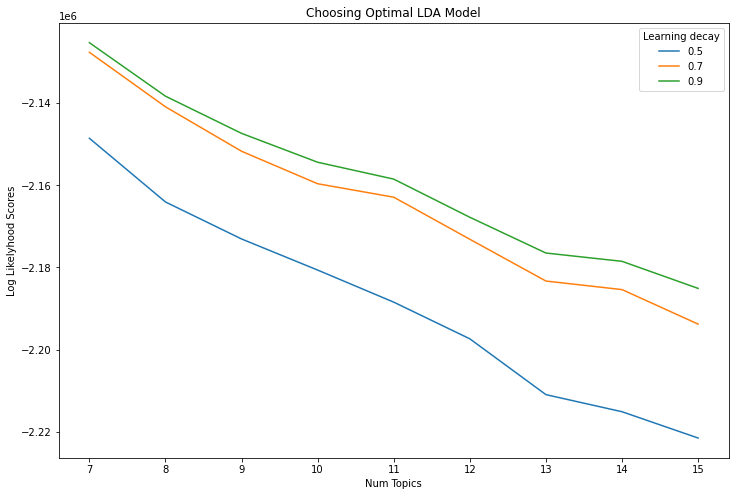

In [87]:
# Get Log Likelyhoods from Grid Search Output: Higher the better
n_topics = [7,8,9,10,11,12,13,14,15]
log_likelyhoods_5 = [round(i) for i in gs.cv_results_['mean_test_score'][0:9]]
log_likelyhoods_7 = [round(i) for i in gs.cv_results_['mean_test_score'][9:18]]
log_likelyhoods_9 = [round(i) for i in gs.cv_results_['mean_test_score'][18:27]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [95]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(best_lda_model, vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('manager', 1689.000347031121), ('get', 1637.2616350222534), ('time', 1489.235208537705), ('employee', 1364.0415502978326), ('management', 1170.8121413117367), ('month', 1025.2167663618518), ('work', 1022.9036072174354), ('like', 993.9566518357675), ('say', 830.6830608618918), ('job', 824.9761458519856)]
Topic 1:
[('system', 2040.2420263756073), ('issue', 1792.6798591555557), ('support', 1759.5949816425648), ('service', 1651.4965596369555), ('customer', 1403.9188076103108), ('application', 1339.0159202860698), ('work', 1253.4555691878402), ('software', 1136.3679232217703), ('network', 961.9725353997785), ('problem', 931.4944383216612)]
Topic 2:
[('work', 10085.649765021011), ('job', 5581.401432127152), ('part', 5484.064307205056), ('enjoy', 3978.3955219774343), ('management', 2918.1943373332283), ('worker', 2496.4480322930385), ('time', 2364.716940928196), ('hour', 2146.088104252344), ('hardest', 2074.5601012936622), ('always', 1999.4740637592383)]
Topic 3:
[('work

In [96]:
 
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=7,init='nndsvd')
nmf_word = nmf_model.fit_transform(data_vectorized)
print(nmf_word.shape)  # (NO_DOCUMENTS, NO_TOPICS)

print(nmf_word[0])


(45251, 7)
[0.         0.         0.         0.06991709 0.08910744 0.03746602
 0.09107326]


In [97]:

 
print("NMF Model:")
print_topics(nmf_model, vectorizer)
print("=" * 20)
 

 

NMF Model:
Topic 0:
[('work', 20.927238702376304), ('life', 1.806457986905793), ('balance', 1.423943392262868), ('environment', 1.4048229803573034), ('culture', 1.1332362403675171), ('place', 1.1224275670137402), ('fun', 0.6899411298816617), ('hour', 0.6101939087322631), ('enjoy', 0.5222765467157835), ('friendly', 0.44080803192008844)]
Topic 1:
[('good', 15.752578928058288), ('place', 1.3015276237610185), ('culture', 1.1411506577223718), ('life', 1.1313355346749163), ('balance', 1.0666884798655027), ('salary', 0.7742363414808621), ('environment', 0.7402634720996671), ('benefit', 0.6399934422898467), ('opportunity', 0.603259661281471), ('experience', 0.531539604855103)]
Topic 2:
[('job', 10.806873863223423), ('part', 6.260830525854979), ('enjoy', 3.2898205940790026), ('hardest', 2.63817744435361), ('worker', 1.4318464296556215), ('customer', 1.3046067822874647), ('typical', 1.0601665534715679), ('would', 0.9524359210558091), ('security', 0.9307448268164324), ('issue', 0.9065601277044812